In [1]:
# JM: 22 May 2021
# scrap notebook to test turning qgm2 data into eddy force function data through FEniCS

from dolfin import *
from qgm2_parameters import *

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import xarray as xr
from numba import jit
import copy

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import interpolate

plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["mathtext.rm"] = "serif"
plt.rcParams["image.cmap"] = "RdBu_r"
plt.rcParams["axes.formatter.limits"] = [-4, 4]
plt.rcParams["font.size"] = 12.0

ntau=80
data_dir0 = "../data/preds/"

finished loading qgm2_parameters


In [2]:
# set up mesh
import matplotlib.tri as tri

mesh = RectangleMesh(Point(0.0, 0.0), Point(L, L), ngrid, ngrid)
space = FunctionSpace(mesh, "CG", 1)
test, trial = TestFunction(space), TrialFunction(space)
zero_bcs = DirichletBC(space, 0.0, "on_boundary")

# some general reusable variables
x_vec, y_vec = np.meshgrid(np.linspace(0, L, ngrid+1), np.linspace(0, L, ngrid+1))
input_points = np.array([x_vec[:].flatten(), y_vec[:].flatten()]).T
output_points = mesh.coordinates()
triang = tri.Triangulation(output_points[:, 0], output_points[:, 1])

# for putting stuff onto mesh
dof_2_vert = dof_to_vertex_map(space)

# for moving stuff onto grid
vert_2_dof = vertex_to_dof_map(space)

In [3]:
# interpolate a function onto the mesh
# FORNOW: do this with eddy PV flux to test eddy force function

# load (non-dimensional) binary data
#   if "*_int.dat", remember to divide by the (non-dim) stime to turn into t_avg data

#TODO: consider defining a class and imbuing this as a subroutine

def load_grid_data(data_dir, filename, layers=layers, tave=False):
    """tidy-up subroutine to load the grid data"""
    grid_data = np.fromfile(data_dir + filename, dtype=np.float64).reshape(layers, ngrid+1, ngrid+1)
    if tave:
        grid_data /= stime
    
    return grid_data

def grid_to_mesh(grid_data, mesh_func):
    """Takes grid data and interpolates it onto a pre-defined finite element mesh"""
    for layer in range(len(mesh_func)):
        data_in = grid_data[layer,:,:]

        # interpolator = interpolate.LinearNDInterpolator(input_points, data_in[:].flatten())
        interpolator = interpolate.NearestNDInterpolator(input_points, data_in[:].flatten())  # much faster
        mesh_func[layer].vector()[:] = interpolator(output_points[dof_2_vert])
        
    return mesh_func

def mesh_to_grid(mesh_func, ny=ngrid+1, nx=ngrid+1):
    """Takes finite element function and pull out data onto regular grid
    
       This subtroutine exploits the fact that the mesh is structued and regular, so just do it
       with vertex_to_dof map. If not regular mesh, will need to write a probing routine,
       or cheat by pulling out vertices then constructing an interpolator.
    """
    layers = len(mesh_func)
    grid_data = np.zeros((layers, ny, nx))
    for l in range(layers):
        grid_data[l, :, :] = np.reshape(mesh_func[l].vector()[vert_2_dof], (ngrid+1, ngrid+1))
        
    return grid_data

In [4]:
# a slower version of James' flux calculator class without using caching from timestepping module

import ufl

class FluxCalculator(object):
    def __init__(self, space, H, s):
        
        """ Imbue object with attributes"""
        
        self.__space  = space
        self.__H      = H
        self.__s      = s
        self.__layers = len(H)
        
        layers = len(H) # local variable for looping
        
        # Stratification
        smat = np.zeros((layers, layers))
        if layers > 1:
            smat[0, 0]   = -float(s[0][1])
            smat[0, 1]   = +float(s[0][1])
            smat[-1, -2] = +float(s[-1][0])
            smat[-1, -1] = -float(s[-1][0])
            for i in range(1, layers - 1):
                smat[i, i - 1] = +float(s[i][0])
                smat[i, i]     = -(float(s[i][0]) + float(s[i][1]))
                smat[i, i + 1] = +float(s[i][1])
        ss, modes_to_z = np.linalg.eig(smat)
        z_to_modes = np.linalg.inv(modes_to_z)
        blayer = 0;  mss = abs(ss[0])
        for i in range(1, len(ss)):
            if abs(ss[i]) < mss:
                blayer = i
                mss = abs(ss[i])
        assert(mss < 1.0e-12)
        ss = [Constant(ss[i]) for i in range(layers)]
        
        self.__ss = ss
        self.__z_to_modes = z_to_modes
        self.__modes_to_z = modes_to_z
    
        self.__space = FunctionSpace(space.mesh(), "CG", 1)
        self.__test, self.__trial = TestFunction(self.__space), TrialFunction(self.__space)
        self.__zero_bcs = DirichletBC(self.__space, 0.0, "on_boundary")
        
        a = inner(self.__test, self.__trial) * dx
        self.__M = assemble(a)
    
        return
    
    def T_c(self, psi, return_K = False):
        
        """Compute mean part to obtain for eddy part later"""
        M = [Function(self.__space, name = "M_%i" % (i + 1)) for i in range(self.__layers)]
        N = [Function(self.__space, name = "N_%i" % (i + 1)) for i in range(self.__layers)]
        P = [Function(self.__space, name = "P_%i" % (i + 1)) for i in range(self.__layers)]
        
        if return_K:
            K = [Function(self.__space, name = "K_%i" % (i + 1)) for i in range(self.__layers)]
        
        print(f"computing mean fluxes at")
        
        for l in range(self.__layers):
            print(f"  layer {l+1}...")
            
            grad_psi = grad(psi[l])
            psi_x, psi_y = grad_psi
            u, v = -psi_y, psi_x
            
            b = assemble(inner(self.__test, 0.5 * (v * v - u * u)) * dx)
            solve(self.__M, M[l].vector(), b)
            
            b = assemble(inner(self.__test, u * v) * dx)
            solve(self.__M, N[l].vector(), b)
            
            P_l = ufl.algebra.Zero()
            if l > 0:
                P_l += 0.25 * self.__s[l][0] * ((psi[l - 1] - psi[l]) ** 2)
            if l < self.__layers - 1:
                P_l += 0.25 * self.__s[l][1] * ((psi[l + 1] - psi[l]) ** 2)
            b = assemble(inner(self.__test, P_l) * dx)
            solve(self.__M, P[l].vector(), b)
            
            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K[l].vector(), b)
            
        R = [Function(self.__space, name = "R_%i" % (i + 1)) for i in range(self.__layers - 1)]
        S = [Function(self.__space, name = "S_%i" % (i + 1)) for i in range(self.__layers - 1)]
        
        if return_K:
            K_i = [Function(self.__space, name = "K_i_%i" % (i + 1)) for i in range(self.__layers - 1)]
            P_i = [Function(self.__space, name = "P_i_%i" % (i + 1)) for i in range(self.__layers - 1)]

        for l in range(self.__layers - 1):
            print(f"  at interface {l+3/2}...")
            
            grad_psi_l = grad(psi[l])
            psi_l_x, psi_l_y = grad_psi_l
            grad_psi_lp1 = grad(psi[l + 1])
            psi_lp1_x, psi_lp1_y = grad_psi_lp1
            u, v = 0.5 * (-psi_l_y - psi_lp1_y), 0.5 * (psi_l_x + psi_lp1_x)

            b = assemble(inner(self.__test, u * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, R[l].vector(), b)

            b = assemble(inner(self.__test, v * self.__H[l] * self.__s[l][1] * (psi[l] - psi[l + 1])) * dx)
            solve(self.__M, S[l].vector(), b)

            if return_K:
                b = assemble(inner(self.__test, 0.5 * (v * v + u * u)) * dx)
                solve(self.__M, K_i[l].vector(), b)

                b = assemble(inner(self.__test, (self.__H[l] / (self.__H[l] + self.__H[l + 1])) 
                    * self.__s[l][1] * (psi[l] - psi[l + 1]) * (psi[l] - psi[l + 1])) * dx)
                solve(self.__M, P_i[l].vector(), b)

        if return_K:
            return M, N, K, P, R, S, K_i, P_i
        else:
            return M, N, P, R, S
        
    def T(self, M = None, N = None, P = None, R = None, S = None):
        
        """Construct the EP (pseudo?)tensor"""
        
        T = [([Function(self.__space, name = "T_xx_%i" % (i + 1)) for i in range(self.__layers)], 
              [Function(self.__space, name = "T_xy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_yx_%i" % (i + 1)) for i in range(self.__layers)],
              [Function(self.__space, name = "T_yy_%i" % (i + 1)) for i in range(self.__layers)]),
             ([Function(self.__space, name = "T_zx_%i" % (i + 1)) for i in range(self.__layers - 1)],
              [Function(self.__space, name = "T_zy_%i" % (i + 1)) for i in range(self.__layers - 1)])]
        
        print(f"filling out the EP tensor")

        for l in range(self.__layers):
            if not M is None:
                T[0][1][l].vector()[:] += M[l].vector()[:]
                T[1][0][l].vector()[:] += M[l].vector()[:]
            if not N is None:
                T[0][0][l].vector()[:] += N[l].vector()[:]
                T[1][1][l].vector()[:] -= N[l].vector()[:]
            if not P is None:
                T[0][1][l].vector()[:] -= P[l].vector()[:]
                T[1][0][l].vector()[:] += P[l].vector()[:]

        for l in range(self.__layers - 1):
            if not R is None:
                T[2][0][l].vector()[:] += R[l].vector()[:]
            if not S is None:
                T[2][1][l].vector()[:] += S[l].vector()[:]

        return T
    
    def uq(self, T, uq = None):
        
        """Construct the PV flux from the EP tensor from a divergence"""
        T_xx, T_xy = T[0]
        T_yx, T_yy = T[1]
        T_zx, T_zy = T[2]
        
        print(f"computing for the PV flux in")

        ruq = [Function(self.__space, name = "uq_%i" % (i + 1)) for i in range(self.__layers)]
        rvq = [Function(self.__space, name = "vq_%i" % (i + 1)) for i in range(self.__layers)]
        for l in range(self.__layers):
            
            print(f"  layer {l+1}")
            
            d_T_x = grad(T_xx[l])[0] + grad(T_yx[l])[1]
            d_T_y = grad(T_xy[l])[0] + grad(T_yy[l])[1]
            if l > 0:
                d_T_x += T_zx[l - 1] / self.__H[l]
                d_T_y += T_zy[l - 1] / self.__H[l]
            if l < self.__layers - 1:
                d_T_x -= T_zx[l] / self.__H[l]
                d_T_y -= T_zy[l] / self.__H[l]

            luq = d_T_x
            if not uq is None:
                luq += uq[0][l]
            b = assemble(inner(self.__test, luq) * dx)
            solve(self.__M, ruq[l].vector(), b)

            lvq = d_T_y
            if not uq is None:
                lvq += uq[1][l]
            b = assemble(inner(self.__test, lvq) * dx)
            solve(self.__M, rvq[l].vector(), b)

        return ruq, rvq
    
    def uq_ffd(self, uq, vq, name = "force_function"):
        
        #print("computing for the appropriate eddy force functions")

        ffd = [Function(self.__space, name = "%s_%i" % (name, i + 1)) for i in range(self.__layers)]
        
        for l in range(self.__layers):
            #print(f"  at layer {l+1}")
            a = -inner(grad(self.__test), grad(self.__trial)) * dx
            L =  inner(grad(self.__test), as_vector([uq[l], vq[l]])) * dx
            solve(a == L, ffd[l], bcs = self.__zero_bcs, solver_parameters={"linear_solver":"lu"})
            
        return ffd
    

uq_c = FluxCalculator(space, H, s)

# uq

In [5]:
fn='empb'
fn_label='q'

In [6]:
uq_grid=np.zeros((3,513,513))
vq_grid=np.zeros((3,513,513))

ff=np.load(data_dir0 +'0/Pr_uvq_%s_00_psi_30.npz'%(fn))
uq_grid[0,:-1,:-1]=ff[ff.files[0]][:-1,:-1]
vq_grid[0,:-1,:-1]=ff[ff.files[1]][:-1,:-1]

In [7]:
uq_noise=grid_to_mesh(uq_grid,[Function(space, name = "noise_u_%i" % (i + 1)) for i in range(layers)])
vq_noise=grid_to_mesh(vq_grid,[Function(space, name = "noise_v_%i" % (i + 1)) for i in range(layers)])

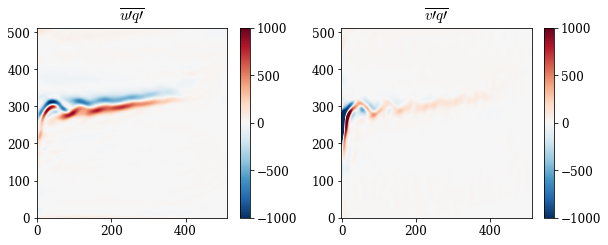

In [8]:
lm=1000

fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(uq_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{u\prime %s\prime}$ '%(fn_label),fontsize=15)

plt.subplot(122)
plt.imshow(vq_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$\overline{v\prime %s\prime}$ '%(fn_label),fontsize=15)

In [9]:
ffd_noise = uq_c.uq_ffd(uq_noise, vq_noise, name = "ffd_noise")

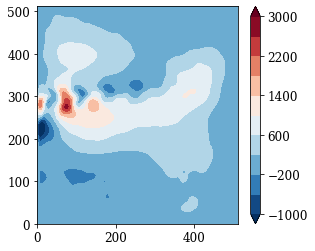

In [10]:
fig = plt.figure(figsize = (4.5, 4))
for layer in range(1):
    ax = plt.subplot(1, 1, layer+1)
    cs = ax.tricontourf(triang,ffd_noise[layer].compute_vertex_values(),origin='lower',levels=np.linspace(-1000,3000,11),extend='both')
    plt.colorbar(cs)

# div

In [11]:
div_p_grid=np.zeros((3,513,513))
div_p_grid[0,:-1,:-1]=np.load(data_dir0 +'0/Pr_div_%s_00_psi_30.npy'%(fn))[:-1,:-1]

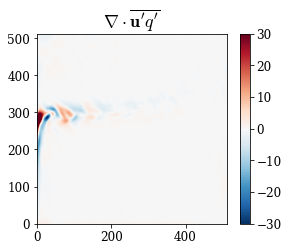

In [12]:
lm=30

fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(div_p_grid[0],origin='lower',vmax=lm,vmin=-lm)#
plt.colorbar()
aa=plt.title(r'$ \nabla \cdot \overline{\mathbf{u}^{\prime} %s^{\prime}} $'%(fn_label),fontsize=18)

In [13]:
div_p_mesh=grid_to_mesh(div_p_grid,[Function(space, name = "pred_div_%i" % (i + 1)) for i in range(layers)])

# solve poisson equation
ffd_p = [Function(space, name = "%s_%i" % ("pred", i + 1)) for i in range(layers)]
for l in range(layers):
    a = inner(grad(test), grad(trial)) * dx
    L = div_p_mesh[l]*test*dx
    solve(a == L, ffd_p[l], bcs = zero_bcs, solver_parameters={"linear_solver":"lu"})

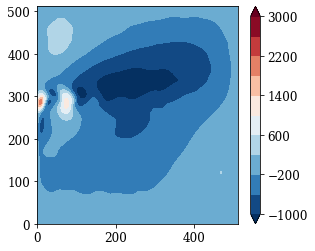

In [14]:
fig = plt.figure(figsize = (4.5, 4))
for layer in range(1):
    ax = plt.subplot(1, 1, layer+1)
    cs = ax.tricontourf(triang,ffd_p[layer].compute_vertex_values(),origin='lower',levels=np.linspace(-1000,3000,11),extend='both')
    plt.colorbar(cs)

# grad

In [24]:
gradp_u_grid=np.zeros((3,513,513))
gradp_v_grid=np.zeros((3,513,513))

ff=np.load(data_dir0 +'0/Pr_grad_%s_00_psi_30.npz'%(fn))
gradp_u_grid[0,:-1,:-1]=ff[ff.files[0]][:-1,:-1]
gradp_v_grid[0,:-1,:-1]=ff[ff.files[1]][:-1,:-1]

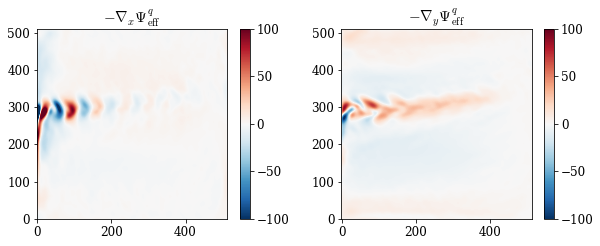

In [25]:
lm0=100
fig=plt.figure(figsize=(10,3.5))
plt.subplot(121)
plt.imshow(-gradp_u_grid[0],origin='lower',vmax=lm0,vmin=-lm0)#
plt.colorbar()
#aa=plt.title(r'<$ -\nabla_x  \Psi_{empb}$ > ',fontsize=15)
aa=plt.title(r'$- \nabla_x  \Psi^%s_{\rm eff}$'%(fn_label),fontsize=15)

plt.subplot(122)
plt.imshow(-gradp_v_grid[0],origin='lower',vmax=lm0,vmin=-lm0)#
plt.colorbar()
#aa=plt.title(r'<$ -\nabla_y \Psi_{empb}$ >  ',fontsize=15)
aa=plt.title(r'$- \nabla_y  \Psi^%s_{\rm eff}$'%(fn_label),fontsize=15)

In [26]:
gradp_u_mesh=grid_to_mesh(gradp_u_grid,[Function(space, name = "pred_eu_%i" % (i + 1)) for i in range(layers)])
gradp_v_mesh=grid_to_mesh(gradp_v_grid,[Function(space, name = "pred_ev_%i" % (i + 1)) for i in range(layers)])

In [27]:
eff_p = [Function(space, name = "eff_p_%i_noise" % (i + 1)) for i in range(layers)] 
for l in range(layers):
    a = inner(grad(trial), grad(test))*dx
    L = inner(as_vector([gradp_u_mesh[l],gradp_v_mesh[l]]), grad(test))*dx
    solve(a == L, eff_p[l], bcs = zero_bcs)

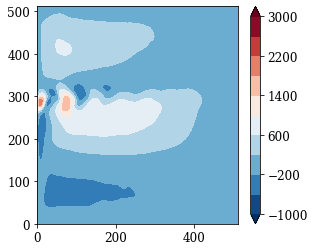

In [28]:
fig = plt.figure(figsize = (4.5, 4))
for layer in range(1):
    ax = plt.subplot(1, 1, layer+1)
    cs = ax.tricontourf(triang,eff_p[layer].compute_vertex_values(),origin='lower',levels=np.linspace(-1000,3000,11),extend='both')
    plt.colorbar(cs)

# plot

In [46]:
def div_to_eff(fn,rni):
    div_p_grid=np.zeros((3,513,513))
    div_p_grid[0,:-1,:-1]=np.load(data_dir0 +'0/Pr_div_%s_00_psi_%s.npy'%(fn,rni))[:-1,:-1]
    div_p_mesh=grid_to_mesh(div_p_grid,[Function(space, name = "pred_a_%i" % (i + 1)) for i in range(layers)])

    # solve poisson equation
    ffd_p = [Function(space, name = "%s_%i" % ("pred", i + 1)) for i in range(layers)]
    for l in range(layers):
        a = inner(grad(test), grad(trial)) * dx
        L = div_p_mesh[l]*test*dx
        solve(a == L, ffd_p[l], bcs = zero_bcs, solver_parameters={"linear_solver":"lu"})
    
    return mesh_to_grid(ffd_p)[0]

def flux_to_eff(fn,rni):
    uq_grid=np.zeros((3,513,513))
    vq_grid=np.zeros((3,513,513))
    ff=np.load(data_dir0 +'0/Pr_uvq_%s_00_psi_%s.npz'%(fn,rni))
    uq_grid[0,:-1,:-1]=ff[ff.files[0]][:-1,:-1]
    vq_grid[0,:-1,:-1]=ff[ff.files[1]][:-1,:-1]
    
    uq_mesh=grid_to_mesh(uq_grid,[Function(space, name = "uq_%i" % (i + 1)) for i in range(layers)])
    vq_mesh=grid_to_mesh(vq_grid,[Function(space, name = "vq_%i" % (i + 1)) for i in range(layers)])
    ffd_mesh = uq_c.uq_ffd(uq_mesh, vq_mesh, name = "ffd")
    
    return mesh_to_grid(ffd_mesh)[0]

def grad_to_eff(fn,rni):
    gradp_u_grid=np.zeros((3,513,513))
    gradp_v_grid=np.zeros((3,513,513))
    ff=np.load(data_dir0 +'0/Pr_grad_%s_00_psi_%s.npz'%(fn,rni))
    gradp_u_grid[0,:-1,:-1]=ff[ff.files[0]][:-1,:-1]
    gradp_v_grid[0,:-1,:-1]=ff[ff.files[1]][:-1,:-1]
    
    gradp_u_mesh=grid_to_mesh(gradp_u_grid,[Function(space, name = "pred_e_%i" % (i + 1)) for i in range(layers)])
    gradp_v_mesh=grid_to_mesh(gradp_v_grid,[Function(space, name = "pred_e_%i" % (i + 1)) for i in range(layers)])
    eff_p = [Function(space, name = "eff_p_%i_noise" % (i + 1)) for i in range(layers)] 
    for l in range(layers):
        a = inner(grad(trial), grad(test))*dx
        L = inner(as_vector([gradp_u_mesh[l],gradp_v_mesh[l]]), grad(test))*dx
        solve(a == L, eff_p[l], bcs = zero_bcs)

    return mesh_to_grid(eff_p)[0]

In [47]:
t_scale=1200
dx_scale=3840e5/512

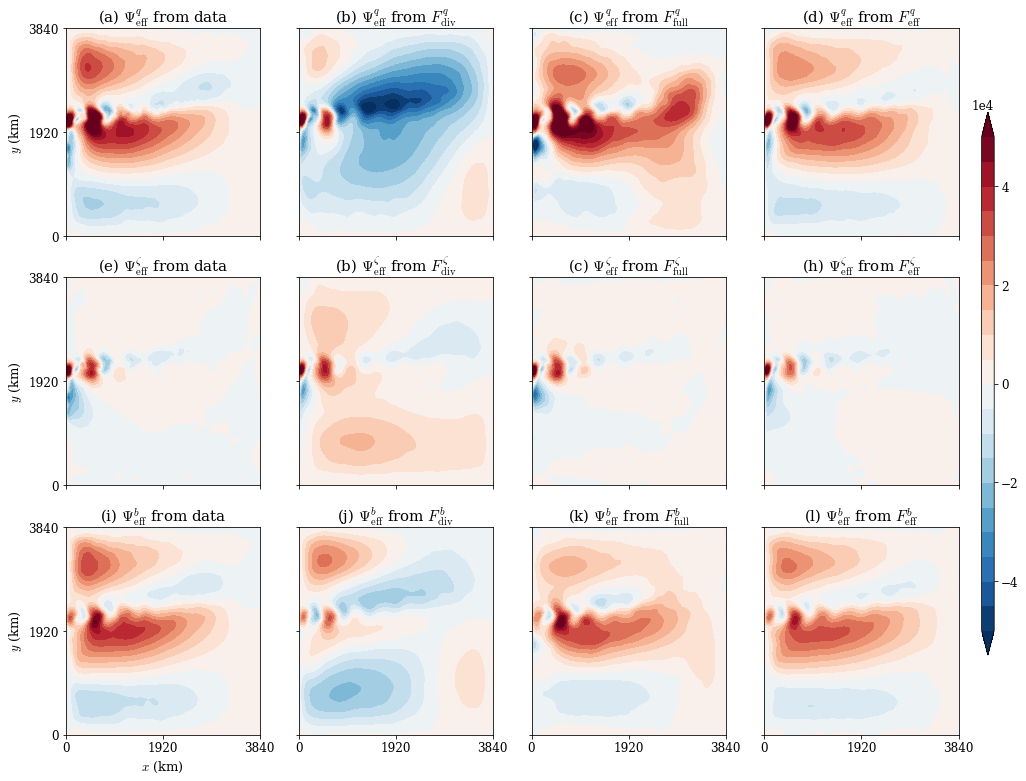

In [48]:
fig=plt.figure(figsize=(16,13))
fn0='q'#
fn='empb'
lm=5e4#
lm0=1e5
rni = 30

ax=plt.subplot(341)
ffd=np.load('../data/training/ffd_%s_80.npy'%(fn))*(dx_scale*dx_scale/t_scale/t_scale)/10000
cs=plt.contourf(x_vec,y_vec,ffd[0],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
ax.set_rasterization_zorder(-1)
aa=plt.title(r"(a) $\Psi^{%s}_{\rm eff}$ from data"%(fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[],fontsize=12)
#plt.xlabel(r'$x$ (km)',fontsize=13)
plt.ylabel(r'$y$ (km)',fontsize=13)

ax=plt.subplot(342)
cs=plt.contourf(x_vec,y_vec,div_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#,
#plt.colorbar()
aa=plt.title(r"(b) $\Psi^{%s}_{\rm eff}$ from $F_{\rm div}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[],fontsize=16)
plt.xticks([0,256,512],[],fontsize=16)
plt.tick_params(labelbottom=False)
ax.set_rasterization_zorder(-1)


ax=plt.subplot(343)
cs=plt.contourf(x_vec,y_vec,flux_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
aa=plt.title(r"(c) $\Psi^{%s}_{\rm eff}$ from $F_{\rm full}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(344)
cs=plt.contourf(x_vec,y_vec,grad_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(d) $\Psi^{%s}_{\rm eff}$ from $F_{\rm eff}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)

ax.set_rasterization_zorder(-1)

fn0='\zeta'
fn='em'
lm=5e4 # 
ax=plt.subplot(345)
ffd=np.load('../data/training/ffd_%s_80.npy'%(fn))*(dx_scale*dx_scale/t_scale/t_scale)/10000
cs=plt.contourf(x_vec,y_vec,ffd[0],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
ax.set_rasterization_zorder(-1)
aa=plt.title(r"(e) $\Psi^{%s}_{\rm eff}$ from data"%(fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[],fontsize=12)
plt.ylabel(r'$y$ (km)',fontsize=13)


ax=plt.subplot(346)
cs=plt.contourf(x_vec,y_vec,div_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#,
#plt.colorbar() 
aa=plt.title(r"(b) $\Psi^{%s}_{\rm eff}$ from $F_{\rm div}^{%s}}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[],fontsize=16)
plt.xticks([0,256,512],[],fontsize=16)
plt.tick_params(labelbottom=False)
ax.set_rasterization_zorder(-1)


ax=plt.subplot(347)
cs=plt.contourf(x_vec,y_vec,flux_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
aa=plt.title(r"(c) $\Psi^{%s}_{\rm eff}$ from $F_{\rm full}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(348)
cs=plt.contourf(x_vec,y_vec,grad_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
aa=plt.title(r"(h) $\Psi^{%s}_{\rm eff}$ from $F_{\rm eff}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=16)
plt.xticks([0,256,512],[0,1920,3840],fontsize=16)
plt.tick_params(labelbottom=False,labelleft=False)

ax.set_rasterization_zorder(-1)


fn0='b'
fn='eb'
lm=.5e5 # 
ax=plt.subplot(349)
ffd=np.load('../data/training/ffd_%s_80.npy'%(fn))*(dx_scale*dx_scale/t_scale/t_scale)/10000
cs=plt.contourf(x_vec,y_vec,ffd[0],levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
ax.set_rasterization_zorder(-1)
aa=plt.title(r"(i) $\Psi^{%s}_{\rm eff}$ from data"%(fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xlabel(r'$x$ (km)',fontsize=13)
plt.ylabel(r'$y$ (km)',fontsize=13)


ax=plt.subplot(3,4,10)
cs=plt.contourf(x_vec,y_vec,div_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#,
#plt.colorbar()
aa=plt.title(r"(j) $\Psi^{%s}_{\rm eff}$ from $F_{\rm div}^{%s}}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(3,4,11)
cs=plt.contourf(x_vec,y_vec,flux_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(k) $\Psi^{%s}_{\rm eff}$ from $F_{\rm full}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)
#plt.xlabel(r'$x$ (km)',fontsize=13)
ax.set_rasterization_zorder(-1)

ax=plt.subplot(3,4,12)
cs=plt.contourf(x_vec,y_vec,grad_to_eff(fn,rni)*(dx_scale*dx_scale/t_scale/t_scale)/10000,levels=np.linspace(-lm,lm,21),extend='both',zorder=-5)#
#plt.colorbar()
aa=plt.title(r"(l) $\Psi^{%s}_{\rm eff}$ from $F_{\rm eff}^{%s}$"%(fn0,fn0),fontsize=15)
plt.yticks([0,256,512],[0,1920,3840],fontsize=12)
plt.xticks([0,256,512],[0,1920,3840],fontsize=12)
plt.tick_params(labelleft=False)


fig.subplots_adjust(right=0.90)
cbar_ax = fig.add_axes([0.92, 0.21, 0.011, 0.58])
fig.colorbar(cs, cax=cbar_ax,ticks=[-.8*lm,-.4*lm, 0,.8*lm,.4*lm])
ax.set_rasterization_zorder(-1)


#fig.savefig('../image/Fig8_%s.pdf'%(rni),bbox_inches='tight',dpi=200)
#fig.savefig('../image/Fig8_%s.png'%(rni),bbox_inches='tight',dpi=200)